In [1]:
# regular imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import math

# default pandas decimal number display format
pd.options.display.float_format = '{:20,.2f}'.format

import warnings
warnings.filterwarnings("ignore")

# Wrangling
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.feature_selection import SelectKBest, RFE, f_regression, SequentialFeatureSelector
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.cluster import KMeans
from scipy import stats
import sklearn.preprocessing
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr, spearmanr, kruskal

import csv
import cc_acquire
import cc_prepare
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import cc_explore

In [ ]:
df = cc_acquire.get_bach_df()

In [2]:
df = cc_acquire.get_bach_df()
df = cc_prepare.clean_college_df(df)

cleaned_df = cc_prepare.clean_step1(df)
new_df = cc_prepare.avg_net_price(cleaned_df)
new_df['major_category'] = new_df.major_name.apply(cc_prepare.categorize_major)

# Ensure you have `2017_2018_2019_earning_by_major.csv` within working folder

new_df = cc_prepare.earnings_merge(new_df)
new_df = cc_prepare.create_roi_cols(new_df)

dataframe shape: (71901, 139)


In [3]:
df = new_df

In [4]:
# Creating income brackets vars
income_0_30000, income_30001_48000, income_48001_75000, income_75001_110000, income_over_110000 = cc_explore.create_merged_income_brackets()

In [5]:
# You can run this code as a single block
df = cc_explore.get_fam_income_col(df, income_0_30000, "fam_income_0_30000")
df = cc_explore.get_fam_income_col(df, income_30001_48000, "fam_income_30001_48000")
df = cc_explore.get_fam_income_col(df, income_48001_75000, "fam_income_48001_75000")
df = cc_explore.get_fam_income_col(df, income_75001_110000, "fam_income_75001_110000")
df = cc_explore.get_fam_income_col(df, income_over_110000, "fam_income_over_110000")

In [6]:
# Standard train_test_split creating our 3 split dfs
train, validate, test = cc_prepare.split_data(df)
print(train.shape)
print(validate.shape)
print(test.shape)

(38385, 134)
(16451, 134)
(13710, 134)


In [ ]:
# skip for now
# Capping outliers on train df
train = explore.percentile_capping(train, 0.1, 0.1)

In [15]:
# Running imputer func on train
train_imputed = cc_explore.train_iterative_imputer(train)

# Performing final imputation on validate and test dfs; 
# Important Note: make sure you do NOT used `train_imputed` with this function. Run the code as shown below:
validate_imputed, test_imputed = cc_explore.impute_val_and_test(train, validate, test)

print(train_imputed.shape)
print(validate_imputed.shape)
print(test_imputed.shape)

(38385, 134)
(16451, 134)
(13710, 134)


## start explore!

* Summary Statistics across majors
* Breakdown of demographics by major (location, gender, socioeconomic background, institution control, part-time vs. full-time enrollment, etc.)

* Geographic Specific Questions:
        Are there differences across where a university/college is located and the ROI earnings?
        Continental US
        State
        Cities 
        Postal Code

In [16]:
train_imputed.shape

(38385, 134)

In [8]:
# add lat and lng for states
location = pd.read_csv('location_info_by_state.csv')
location = location.rename(columns={"state": "state_post_code"})
train = pd.merge(train, location, how = 'left', on = 'state_post_code')
train.shape

(38385, 136)

In [7]:
cc_prepare.nulls_by_col(train).head()

,num_rows_missing,percent_rows_missing
med_parent_and_pell,37211,96.94
avg_parent_and_pell,36331,94.65
med_monthly_payment_parent_and_debt,34309,89.38
med_parent_and_loan,34309,89.38
avg_parent_and_loan,33218,86.54


In [7]:
col = ['avg_net_price_public', 'avg_net_price_private']
df = df.drop(columns = col)
df.shape

(68546, 149)

In [16]:
# cc_prepare.nulls_by_col(train).head()

In [35]:
train.shape

(38385, 136)

### get the basic info columns

In [60]:
train.columns.tolist()

['unit_id_institution',
 'college_name',
 'institution_control',
 'state_post_code',
 'zip_code',
 'city',
 'region_ipeds',
 'title_IV_eligibility',
 'pred_degree',
 'pred_degree_0and4',
 'degree_name',
 'degree_code',
 'major_code',
 'major_name',
 'branch_number',
 'avg_net_price_public',
 'avg_net_price_private',
 'title_IV_student_number',
 'full_time_net_tuition_revenue',
 'off_campus_cost_of_attendace',
 'on_campus_cost_of_attendace',
 'admission_rate',
 'graduate_number',
 'ACT_score_mid',
 'avg_sat_admitted',
 'required_score',
 'avg_faculty_salary',
 'online_only',
 'comp_rt_ft_150over_expected_time',
 'comp_rt_ft_150over_expected_time_two_races',
 'comp_rt_ft_150over_expected_time_native_american',
 'comp_rt_ft_150over_expected_time_asian',
 'comp_rt_ft_150over_expected_time_black',
 'comp_rt_ft_150over_expected_time_hispanic',
 'comp_rt_ft_150over_expected_time_non_resident',
 'comp_rt_ft_150over_expected_time_unknown_race',
 'comp_rt_ft_150over_expected_time_white',
 'share

In [71]:
basic_info_cols = ['college_name','institution_control',
                   'state_post_code','city','title_IV_eligibility',
                   'major_name','title_IV_student_number','admission_rate', 
                   'online_only','enrollment_share_two_races','enrollment_share_native_american',
                   'enrollment_share_asian','enrollment_share_black',
                   'enrollment_share_hispanic','enrollment_share_pac_islander',
                   'enrollment_share_non_resident','enrollment_share_unknown',
                   'enrollment_share_white','major_category','2017','2018','2019','Grand Total',
                   'roi_5yr','pct_roi_5yr','roi_10yr','pct_roi_10yr','roi_20yr',
                   'pct_roi_20yr','avg_sat_admitted','ACT_score_mid','latitude','longitude','zip_code']
train1 = train[basic_info_cols]
train1.head()

,college_name,institution_control,state_post_code,city,title_IV_eligibility,major_name,title_IV_student_number,admission_rate,online_only,enrollment_share_two_races,...,pct_roi_5yr,roi_10yr,pct_roi_10yr,roi_20yr,pct_roi_20yr,avg_sat_admitted,ACT_score_mid,latitude,longitude,zip_code
0,Baker College,"Private, nonprofit",MI,Owosso,1.00,"Liberal Arts and Sciences, General Studies and...",439.00,0.80,0.00,0.04,...,36.68,1.87,186.52,5.35,534.60,NaN,NaN,44.31,-85.60,48867
1,Widener University,"Private, nonprofit",PA,Chester,1.00,Physics.,649.00,0.69,0.00,0.04,...,37.91,1.94,193.77,5.56,555.86,"1,115.00",23.00,41.20,-77.19,19013-5792
2,William Peace University,"Private, nonprofit",NC,Raleigh,1.00,Criminal Justice and Corrections.,181.00,0.57,0.00,0.04,...,15.08,1.44,143.99,4.43,443.45,"1,042.00",21.00,35.76,-79.02,27604-1194
3,Robert Morris University,"Private, nonprofit",PA,Moon Township,1.00,Health and Physical Education/Fitness.,721.00,0.84,0.00,0.03,...,-5.48,1.00,100.11,3.45,345.41,"1,131.00",25.00,41.20,-77.19,15108-1189
4,Northwestern University,"Private, nonprofit",IL,Evanston,1.00,Urban Studies/Affairs.,775.00,0.08,0.00,0.06,...,16.11,1.48,147.89,4.54,454.00,"1,508.00",34.00,40.63,-89.40,60208


In [20]:
train1[train1.admission_rate.isnull()].reset_index().major_category.value_counts()

Series([], Name: major_category, dtype: int64)

In [72]:
train1['admission_rate'] = train1.groupby('major_category')['admission_rate'].apply(lambda x:x.fillna(x.mean()))
train1['ACT_score_mid'] = train1.groupby('major_category')['ACT_score_mid'].apply(lambda x:x.fillna(x.mean()))
train1['avg_sat_admitted'] = train1.groupby('major_category')['avg_sat_admitted'].apply(lambda x:x.fillna(x.mean()))

In [172]:
# train1['admission_rate'] = train1['admission_rate'].fillna(df.groupby('major_category')['admission_rate'].transform('mean'))

In [ ]:
def fill_null_with_mean(df):
    '''fill the null value with avg for each major'''
    
    df['admission_rate'] = df.groupby('major_category')['admission_rate'].apply(lambda x:x.fillna(x.mean()))
    df['ACT_score_mid'] = df.groupby('major_category')['ACT_score_mid'].apply(lambda x:x.fillna(x.mean()))
    df['avg_sat_admitted'] = df.groupby('major_category')['avg_sat_admitted'].apply(lambda x:x.fillna(x.mean()))
    return df

In [74]:
train1['enrollment_share_asian'] = train1['enrollment_share_asian'].fillna(0)
train1['enrollment_share_two_races'] = train1['enrollment_share_two_races'].fillna(0)
train1['enrollment_share_unknown'] = train1['enrollment_share_unknown'].fillna(0)
train1['enrollment_share_non_resident'] = train1['enrollment_share_non_resident'].fillna(0)
train1['enrollment_share_pac_islander'] = train1['enrollment_share_pac_islander'].fillna(0)
train1['enrollment_share_hispanic'] = train1['enrollment_share_hispanic'].fillna(0)
train1['enrollment_share_black'] = train1['enrollment_share_black'].fillna(0)
train1['enrollment_share_native_american'] = train1['enrollment_share_native_american'].fillna(0)
train1['enrollment_share_white'] = train1['enrollment_share_white'].fillna(0)

In [75]:
cc_prepare.nulls_by_col(train1).head(10)

,num_rows_missing,percent_rows_missing
title_IV_student_number,16998,44.28
longitude,44,0.11
latitude,44,0.11
college_name,0,0.00
roi_10yr,0,0.00
2018,0,0.00
2019,0,0.00
Grand Total,0,0.00
roi_5yr,0,0.00
pct_roi_5yr,0,0.00


## Major
### 1. How is the majors summary in US?

<AxesSubplot:xlabel='count', ylabel='major_category'>

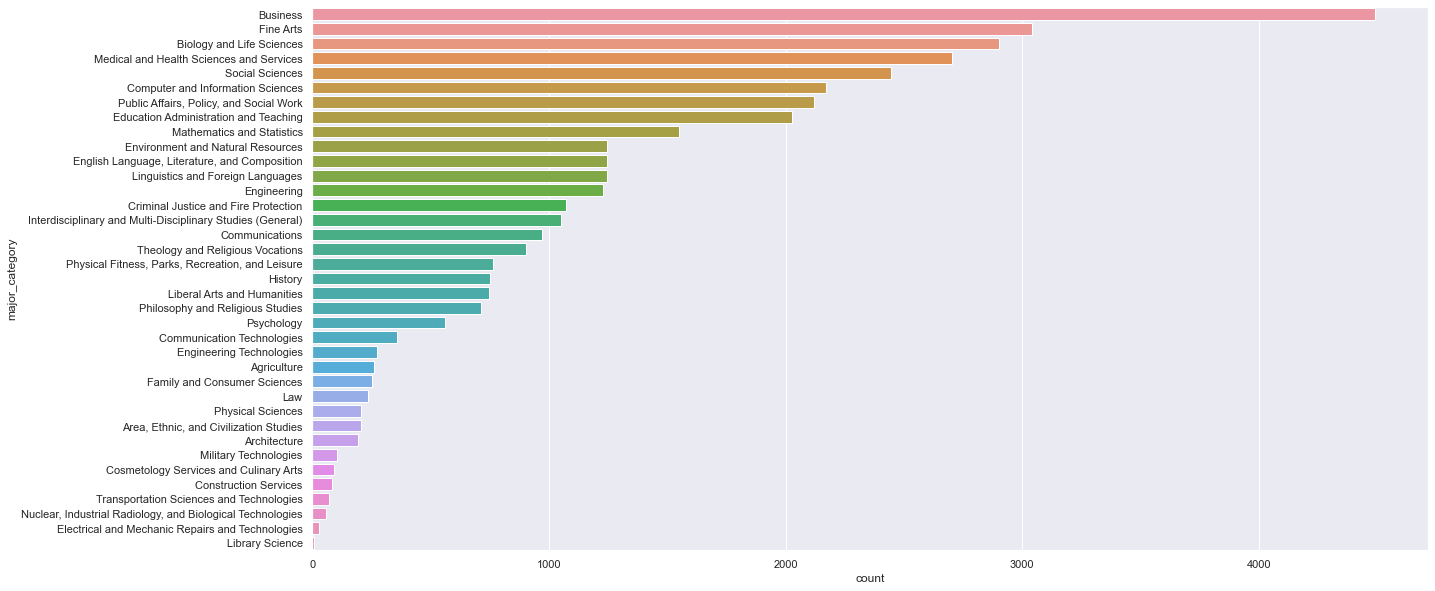

In [17]:
plt.figure(figsize=(20,10))
sns.countplot(y='major_category', data=train, order = train1['major_category'].value_counts().index)

In [18]:
# top 10
train1.major_category.value_counts().head(10)

Business                                    4491
Fine Arts                                   3041
Biology and Life Sciences                   2902
Medical and Health Sciences and Services    2702
Social Sciences                             2446
Computer and Information Sciences           2170
Public Affairs, Policy, and Social Work     2120
Education Administration and Teaching       2026
Mathematics and Statistics                  1551
Environment and Natural Resources           1247
Name: major_category, dtype: int64

* Top 10 majors:
    1. Business
    2. Fine Arts                     
    3. Biology and Life Sciences                
    4. Medical and Health Sciences and Services   
    5. Social Sciences      
    6. Computer and Information Sciences      
    7. Public Affairs, Policy, and Social Work  
    8. Education Administration and Teaching   
    9. Mathematics and Statistics     
    10. Environment and Natural Resources    

In [76]:
# least 10
train1.major_category.value_counts().tail(10)

Physical Sciences                                             207
Area, Ethnic, and Civilization Studies                        206
Architecture                                                  195
Military Technologies                                         103
Cosmetology Services and Culinary Arts                         91
Construction Services                                          85
Transportation Sciences and Technologies                       71
Nuclear, Industrial Radiology, and Biological Technologies     59
Electrical and Mechanic Repairs and Technologies               29
Library Science                                                 8
Name: major_category, dtype: int64

### 2. Major summary in different school type

### public

<AxesSubplot:xlabel='count', ylabel='major_category'>

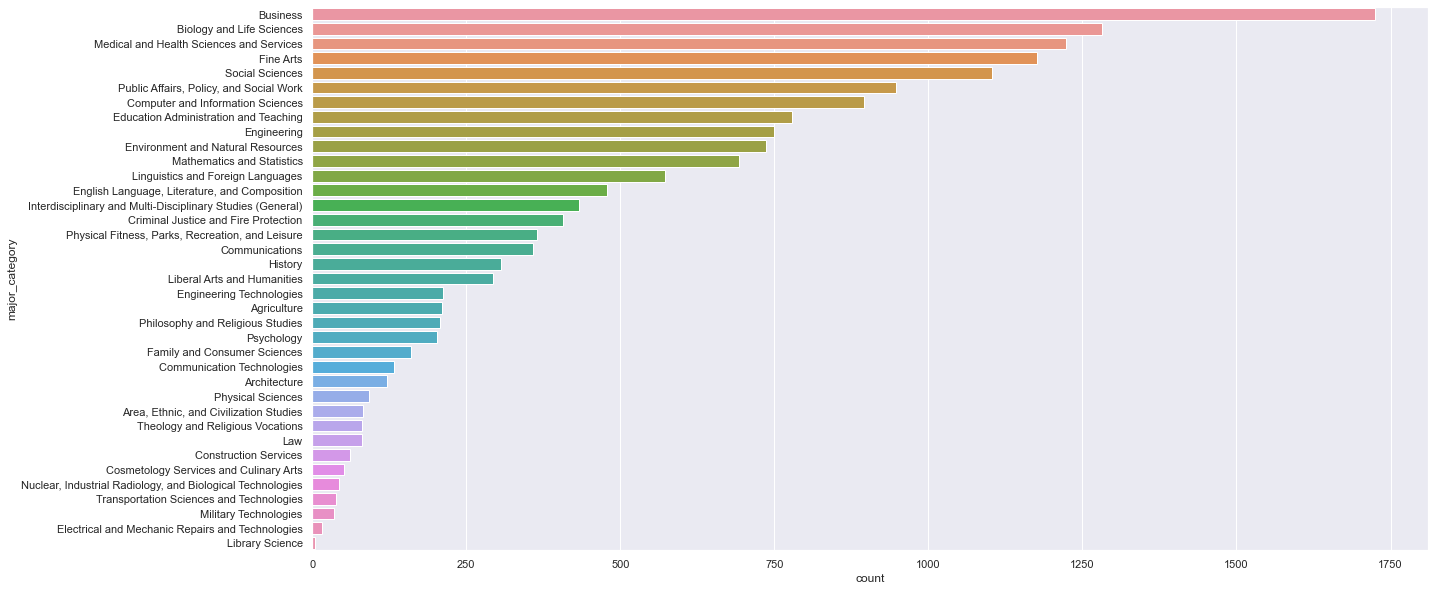

In [22]:
# public
plt.figure(figsize=(20,10))
sns.countplot(y='major_category', data=train1[train1.institution_control == 'Public'],
              order = train1[train1.institution_control == 'Public']['major_category'].value_counts().index)

In [23]:
# top 5
train1[train1.institution_control == 'Public'].major_category.value_counts().head()

Business                                    1725
Biology and Life Sciences                   1281
Medical and Health Sciences and Services    1223
Fine Arts                                   1177
Social Sciences                             1104
Name: major_category, dtype: int64

In [24]:
# least 5
train1[train1.institution_control == 'Public'].major_category.value_counts().tail()

Nuclear, Industrial Radiology, and Biological Technologies    43
Transportation Sciences and Technologies                      38
Military Technologies                                         35
Electrical and Mechanic Repairs and Technologies              16
Library Science                                                5
Name: major_category, dtype: int64

### Private, for-profit

<AxesSubplot:xlabel='count', ylabel='major_category'>

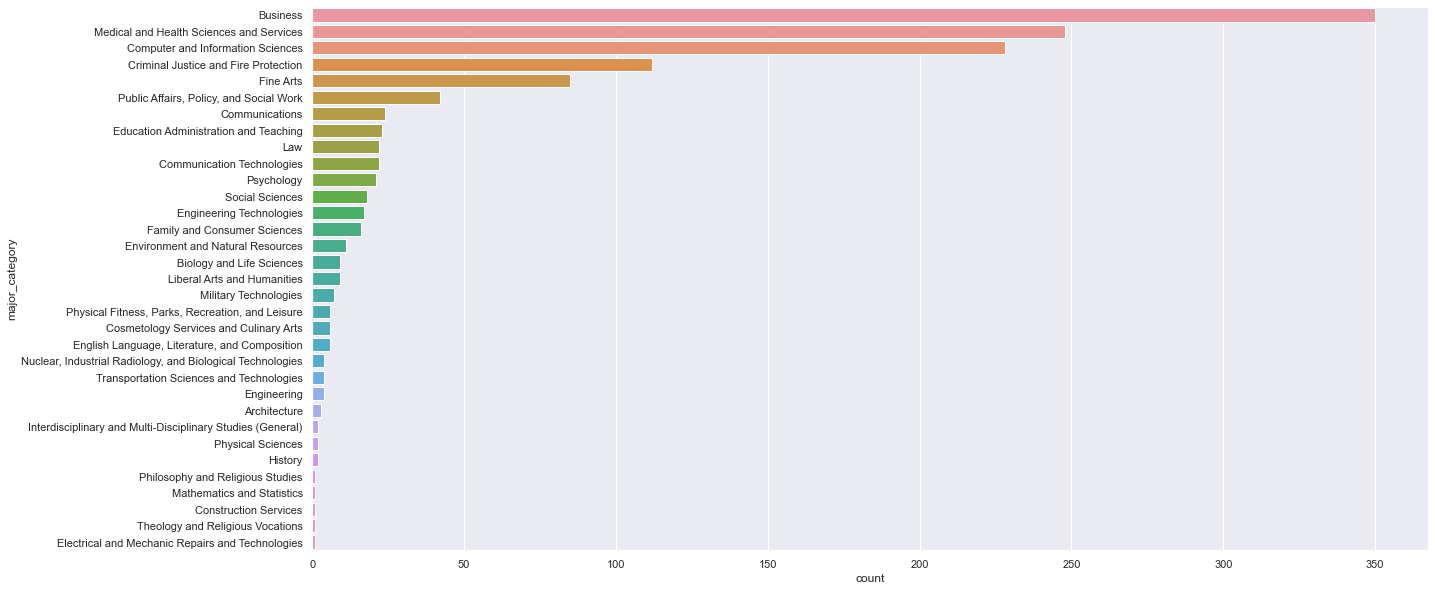

In [25]:
# Private, for-profit
plt.figure(figsize=(20,10))
sns.countplot(y='major_category', data=train[train1.institution_control == 'Private, for-profit'],
              order = train1[train1.institution_control == 'Private, for-profit']['major_category'].value_counts().index)

In [26]:
# top 5
train1[train1.institution_control == 'Private, for-profit'].major_category.value_counts().head()

Business                                    350
Medical and Health Sciences and Services    248
Computer and Information Sciences           228
Criminal Justice and Fire Protection        112
Fine Arts                                    85
Name: major_category, dtype: int64

In [27]:
# least 5
train1[train1.institution_control == 'Private, for-profit'].major_category.value_counts().tail()

Philosophy and Religious Studies                    1
Mathematics and Statistics                          1
Construction Services                               1
Theology and Religious Vocations                    1
Electrical and Mechanic Repairs and Technologies    1
Name: major_category, dtype: int64

### Private, nonprofit

<AxesSubplot:xlabel='count', ylabel='major_category'>

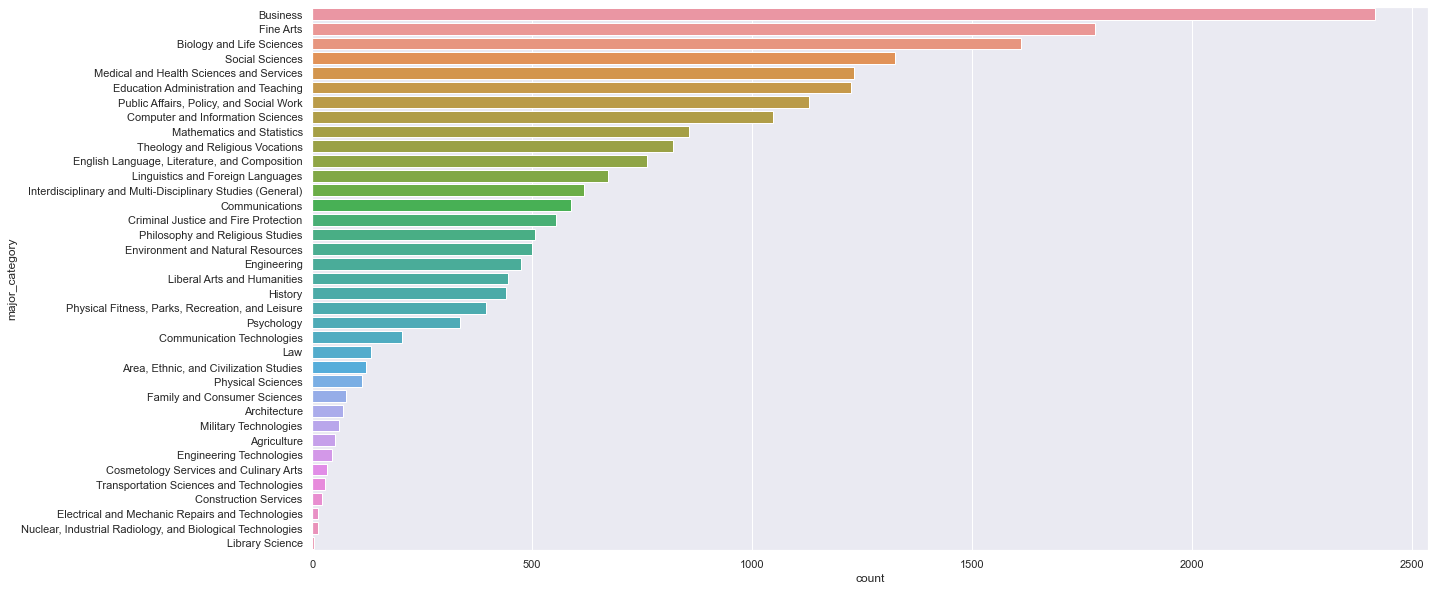

In [28]:
# Private, nonprofit
plt.figure(figsize=(20,10))
sns.countplot(y='major_category', data=train1[train1.institution_control == 'Private, nonprofit'],
              order = train1[train1.institution_control == 'Private, nonprofit']['major_category'].value_counts().index)

In [29]:
# top 5
train1[train1.institution_control == 'Private, nonprofit'].major_category.value_counts().head()

Business                                    2416
Fine Arts                                   1779
Biology and Life Sciences                   1612
Social Sciences                             1324
Medical and Health Sciences and Services    1231
Name: major_category, dtype: int64

In [30]:
# least 5
train1[train1.institution_control == 'Private, nonprofit'].major_category.value_counts().tail()

Transportation Sciences and Technologies                      29
Construction Services                                         23
Electrical and Mechanic Repairs and Technologies              12
Nuclear, Industrial Radiology, and Biological Technologies    12
Library Science                                                3
Name: major_category, dtype: int64

### maybe not necessary to show

### 3. top 10 ROI across majors.

### 5-year

<AxesSubplot:xlabel='roi_5yr', ylabel='major_category'>

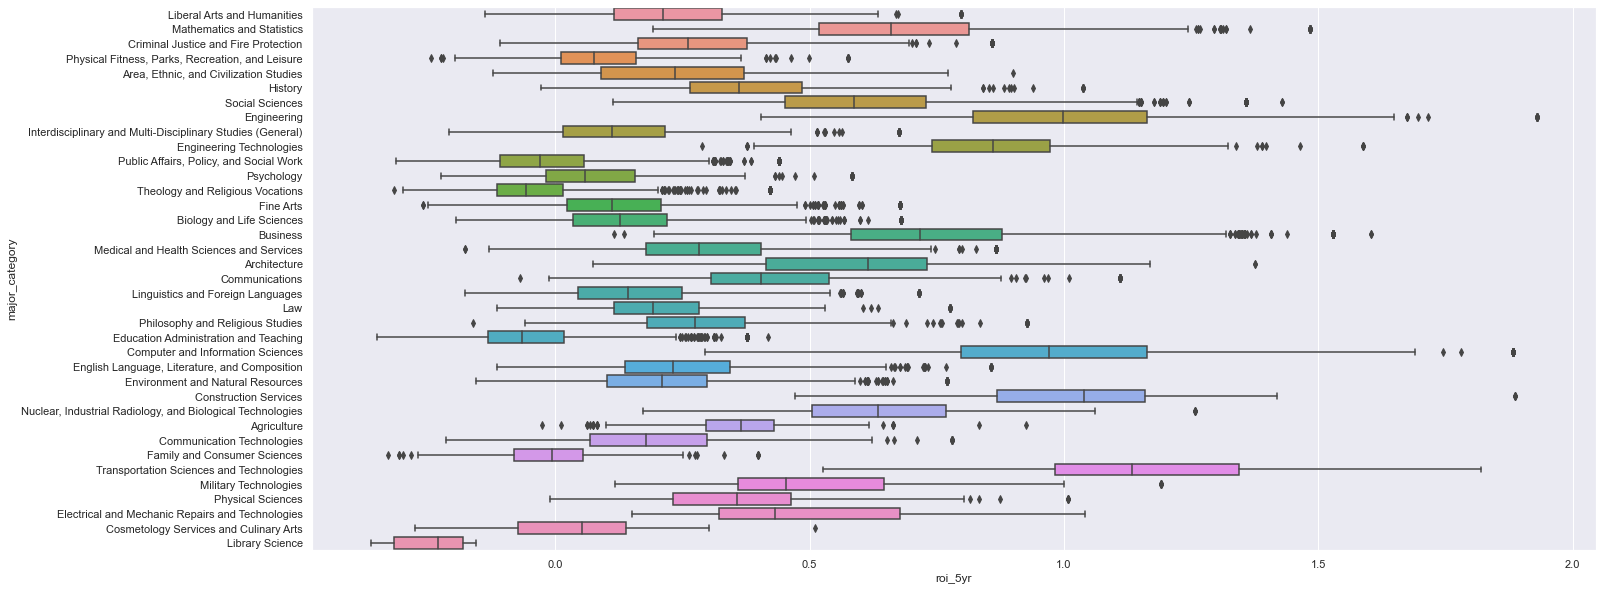

In [48]:
plt.figure(figsize=(23, 10))
sns.boxplot(y='major_category', x='roi_5yr', data = train1)

In [49]:
# top ten ROI avg majors
train1.groupby('major_category').roi_5yr.mean().nlargest(10)

major_category
Transportation Sciences and Technologies                                     1.15
Construction Services                                                        1.04
Computer and Information Sciences                                            1.01
Engineering                                                                  1.00
Engineering Technologies                                                     0.86
Business                                                                     0.75
Mathematics and Statistics                                                   0.67
Nuclear, Industrial Radiology, and Biological Technologies                   0.65
Social Sciences                                                              0.60
Architecture                                                                 0.58
Name: roi_5yr, dtype: float64

### 10-year and 20-year are the same answer

## 4. Admission rate by major
* impute null with total avg by major

In [53]:
train1.admission_rate.mean()

0.6803626473070051

<AxesSubplot:xlabel='admission_rate', ylabel='major_category'>

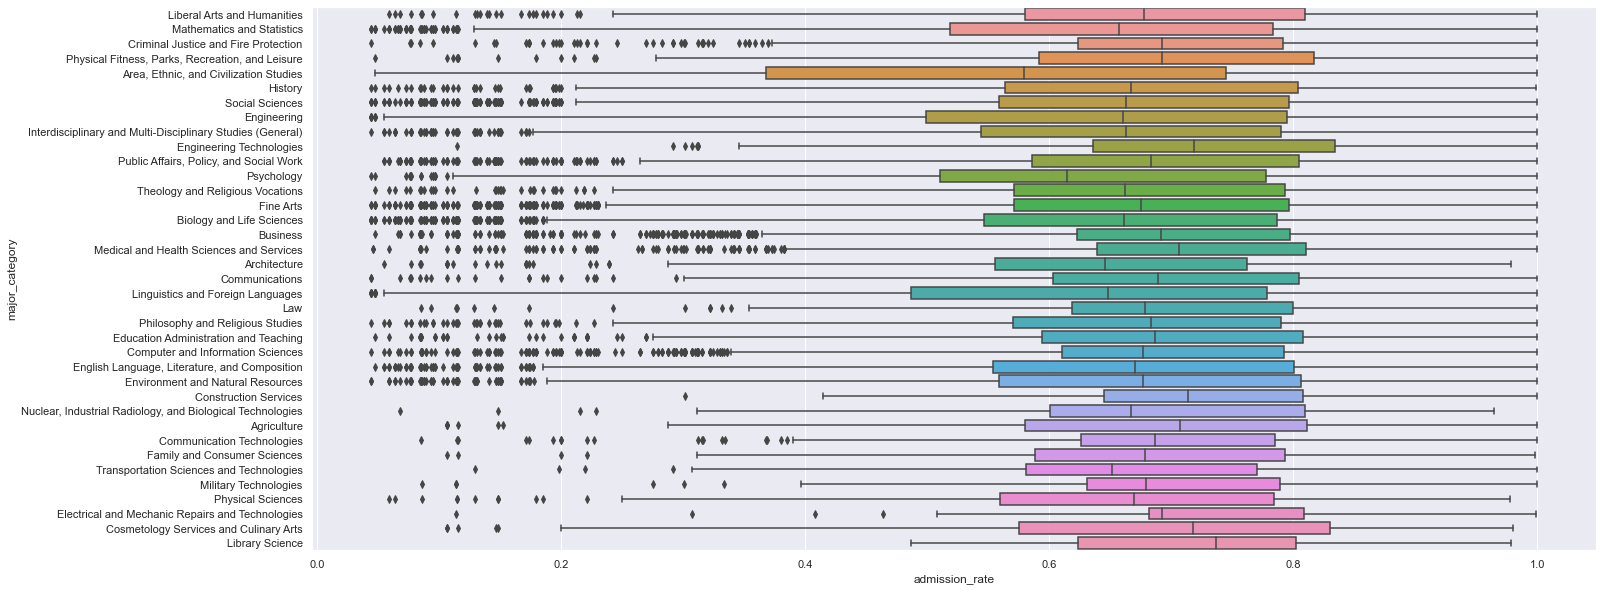

In [27]:
plt.figure(figsize=(23, 10))
sns.boxplot(y='major_category', x='admission_rate', data = train1)

<AxesSubplot:xlabel='admission_rate', ylabel='major_category'>

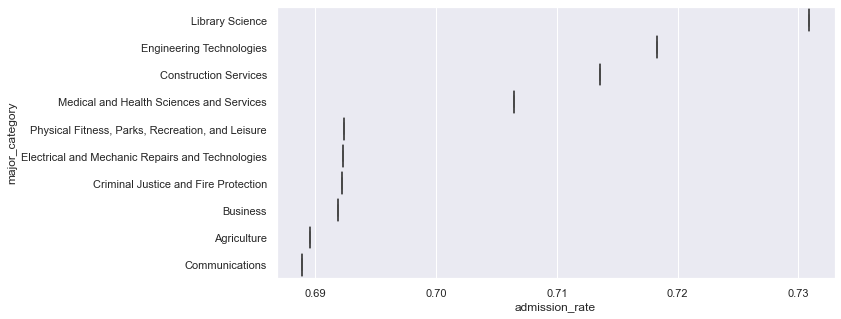

In [28]:
# top 10
plt.figure(figsize=(10, 5))
top10_admission_rate_major = train1.groupby('major_category').admission_rate.mean().nlargest(10).reset_index()
sns.boxplot(y='major_category',x='admission_rate', data = top10_admission_rate_major)

### 5. avg sat score by major

<AxesSubplot:xlabel='avg_sat_admitted', ylabel='major_category'>

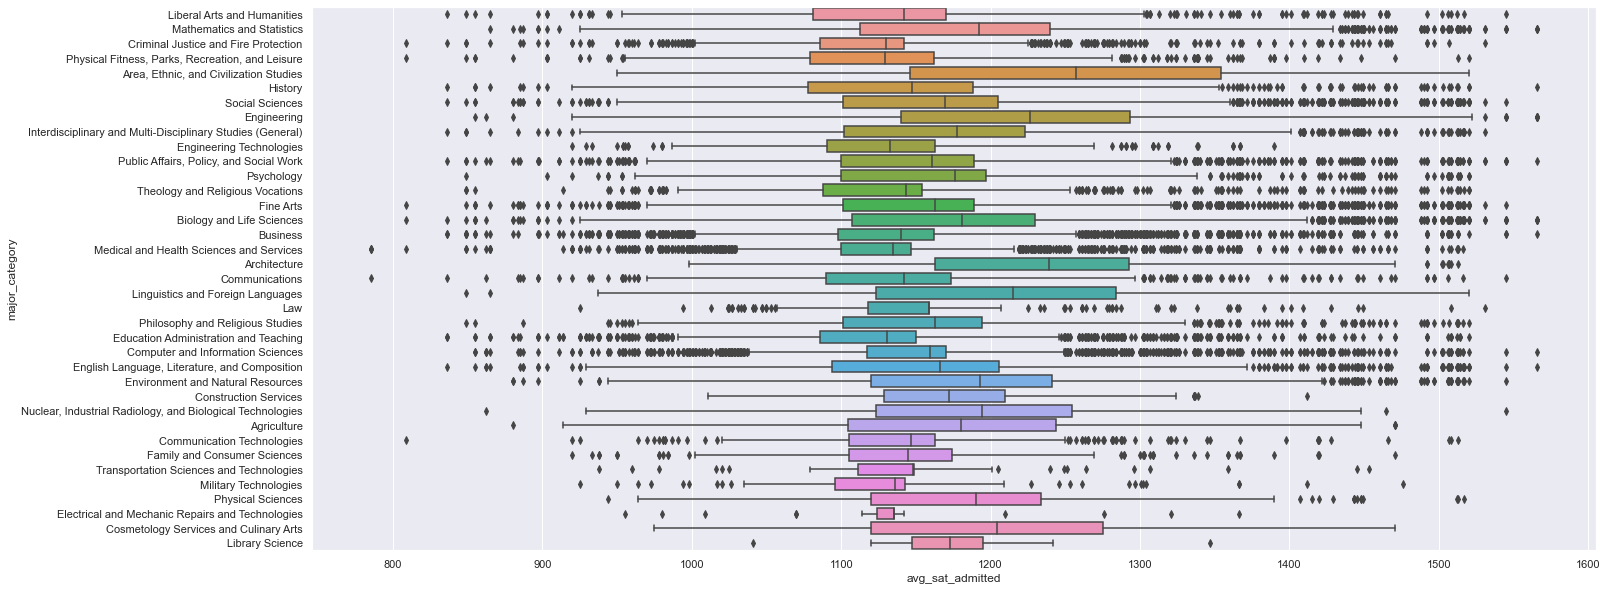

In [29]:
plt.figure(figsize=(23, 10))
sns.boxplot(y='major_category', x='avg_sat_admitted', data = train1)

<AxesSubplot:xlabel='avg_sat_admitted', ylabel='major_category'>

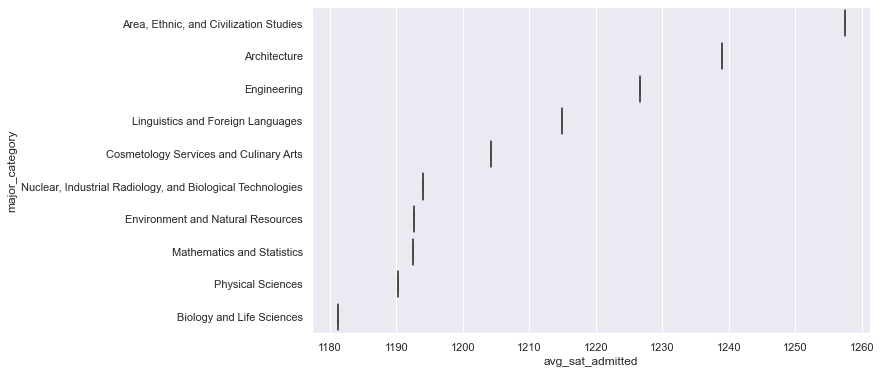

In [31]:
# top 10 avg sat score
plt.figure(figsize=(10, 6))
top10_sat_score_major = train1.groupby('major_category').avg_sat_admitted.mean().nlargest(10).reset_index()
sns.boxplot(y='major_category',x='avg_sat_admitted', data = top10_sat_score_major)

### 5. ACT_score_mid by major

<AxesSubplot:xlabel='ACT_score_mid', ylabel='major_category'>

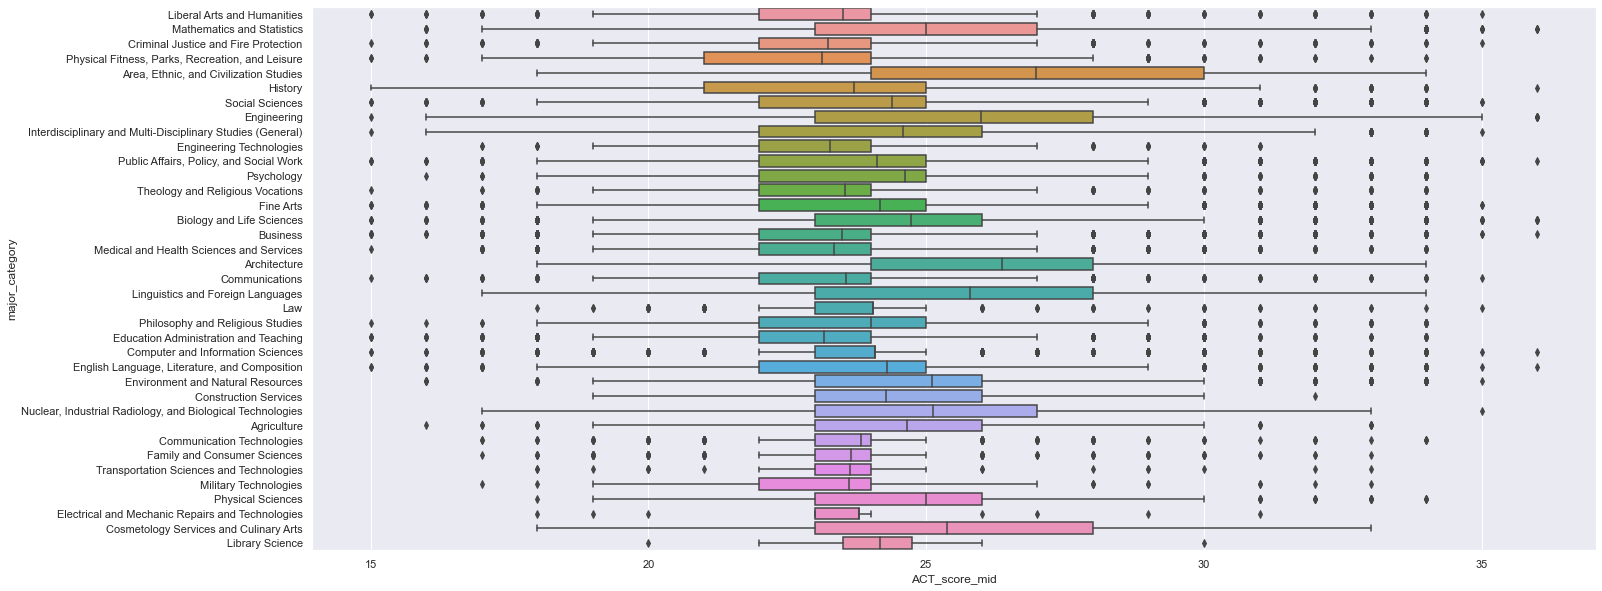

In [32]:
plt.figure(figsize=(23, 10))
sns.boxplot(y='major_category', x='ACT_score_mid', data = train1)

<AxesSubplot:xlabel='ACT_score_mid', ylabel='major_category'>

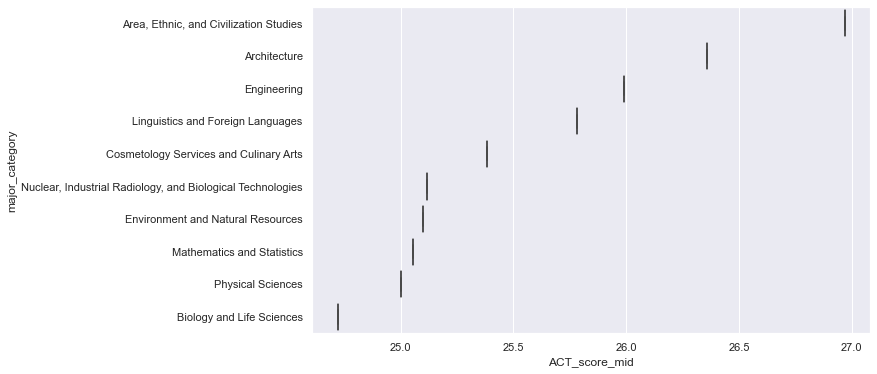

In [33]:
# top 10 avg sat score
plt.figure(figsize=(10, 6))
top10_act_score_major = train1.groupby('major_category').ACT_score_mid.mean().nlargest(10).reset_index()
sns.boxplot(y='major_category',x='ACT_score_mid', data = top10_act_score_major)

### 6. race by major
* impute null value as 0

        enrollment_share_asian
        enrollment_share_two_races
        enrollment_share_unknown
        enrollment_share_non_resident
        enrollment_share_pac_islander
        enrollment_share_hispanic
        enrollment_share_black
        enrollment_share_native_american
        enrollment_share_white

In [42]:
train1['enrollment_share_asian'] = train1['enrollment_share_asian'].fillna(0)
train1['enrollment_share_two_races'] = train1['enrollment_share_two_races'].fillna(0)
train1['enrollment_share_unknown'] = train1['enrollment_share_unknown'].fillna(0)
train1['enrollment_share_non_resident'] = train1['enrollment_share_non_resident'].fillna(0)
train1['enrollment_share_pac_islander'] = train1['enrollment_share_pac_islander'].fillna(0)
train1['enrollment_share_hispanic'] = train1['enrollment_share_hispanic'].fillna(0)
train1['enrollment_share_black'] = train1['enrollment_share_black'].fillna(0)
train1['enrollment_share_native_american'] = train1['enrollment_share_native_american'].fillna(0)
train1['enrollment_share_white'] = train1['enrollment_share_white'].fillna(0)

In [44]:
# cc_prepare.nulls_by_col(train1).head()

<AxesSubplot:xlabel='enrollment_share_white', ylabel='major_category'>

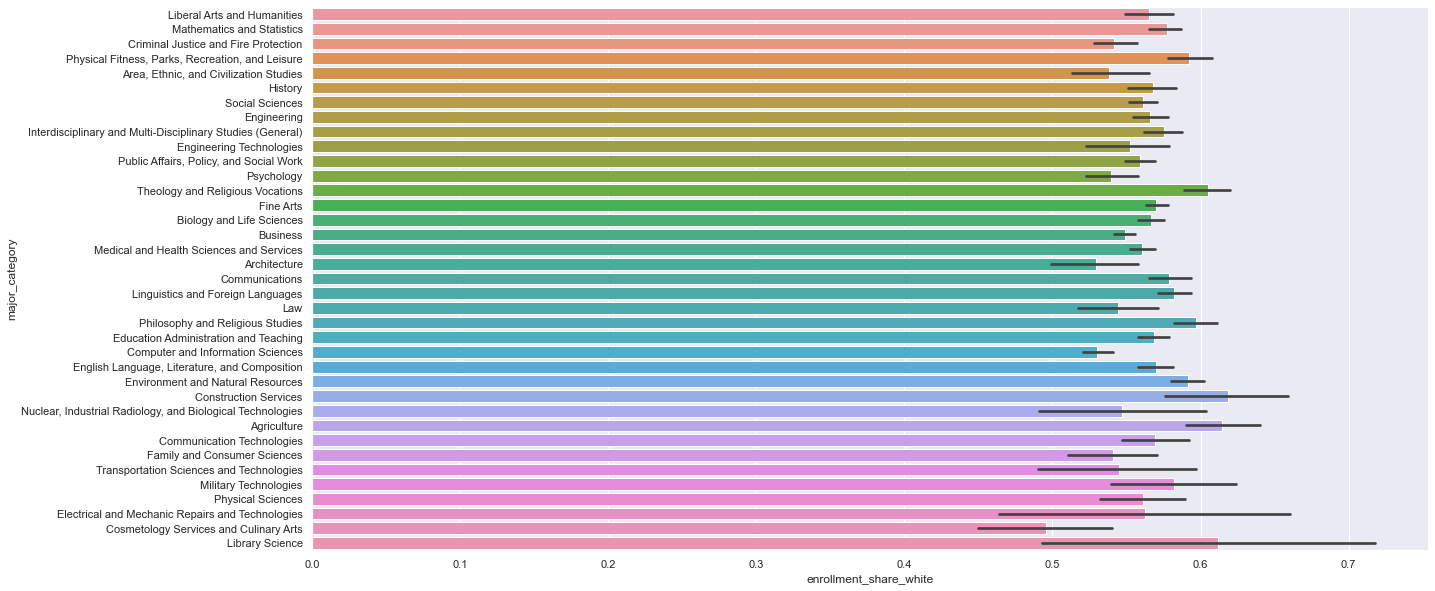

In [34]:
plt.figure(figsize=(20,10))
sns.barplot(y='major_category', x='enrollment_share_white', data=train1)

In [35]:
train1.groupby('major_category').enrollment_share_asian.mean().nlargest()

major_category
Area, Ethnic, and Civilization Studies                   0.09
Architecture                                             0.09
Cosmetology Services and Culinary Arts                   0.08
Engineering                                              0.08
Linguistics and Foreign Languages                        0.07
Name: enrollment_share_asian, dtype: float64

In [36]:
train1.groupby('major_category').enrollment_share_black.mean().nlargest()

major_category
Criminal Justice and Fire Protection                                         0.15
Engineering Technologies                                                     0.15
Family and Consumer Sciences                                                 0.15
Transportation Sciences and Technologies                                     0.15
Nuclear, Industrial Radiology, and Biological Technologies                   0.15
Name: enrollment_share_black, dtype: float64

In [61]:
train1.groupby('major_category').enrollment_share_white.mean().nlargest()

major_category
Construction Services                              0.62
Agriculture                                        0.61
Library Science                                    0.61
Theology and Religious Vocations                   0.60
Philosophy and Religious Studies                   0.60
Name: enrollment_share_white, dtype: float64

In [62]:
train1.groupby('major_category').enrollment_share_two_races.mean().nlargest()

major_category
Area, Ethnic, and Civilization Studies                   0.04
Agriculture                                              0.04
Linguistics and Foreign Languages                        0.04
Cosmetology Services and Culinary Arts                   0.04
Architecture                                             0.04
Name: enrollment_share_two_races, dtype: float64

In [63]:
train1.groupby('major_category').enrollment_share_hispanic.mean().nlargest()

major_category
Electrical and Mechanic Repairs and Technologies                   0.22
Cosmetology Services and Culinary Arts                             0.18
Physical Sciences                                                  0.16
Military Technologies                                              0.15
Computer and Information Sciences                                  0.15
Name: enrollment_share_hispanic, dtype: float64

## 2. Geographic

### 1. ROI by states

<AxesSubplot:xlabel='state_post_code', ylabel='roi_5yr'>

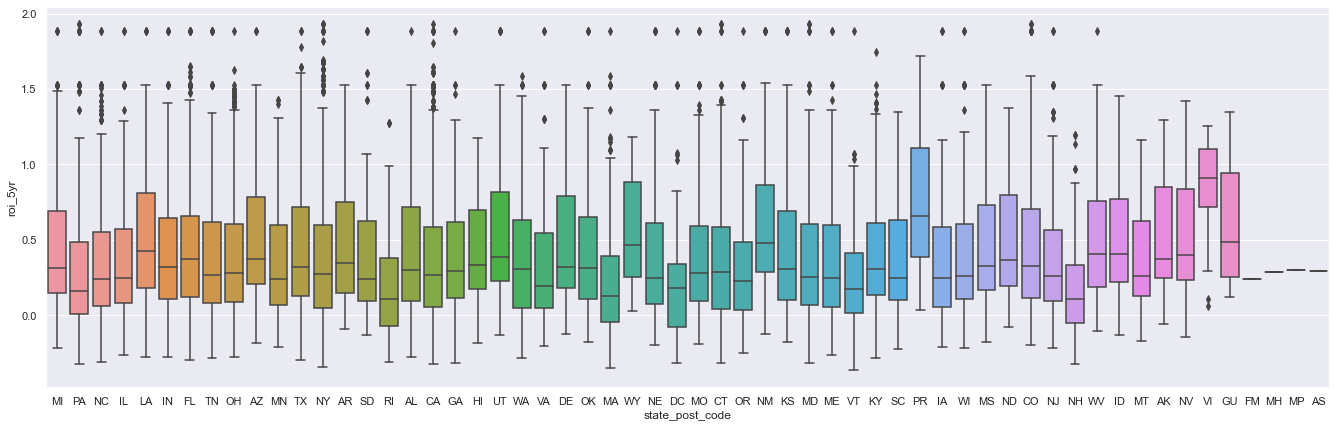

In [37]:
plt.figure(figsize=(23, 7))
sns.boxplot(x='state_post_code', y='roi_5yr', data = train1)

In [38]:
train1.groupby('state_post_code').roi_5yr.mean().nlargest(10)

state_post_code
VI                   0.82
PR                   0.75
NM                   0.61
GU                   0.58
WY                   0.56
UT                   0.53
AK                   0.52
WV                   0.50
NV                   0.50
ID                   0.49
Name: roi_5yr, dtype: float64

In [39]:
train1.groupby('state_post_code').roi_10yr.mean().nlargest(10)

state_post_code
VI                   2.86
PR                   2.70
NM                   2.40
GU                   2.34
WY                   2.31
UT                   2.23
AK                   2.21
WV                   2.17
NV                   2.17
ID                   2.16
Name: roi_10yr, dtype: float64

In [40]:
train1.groupby('state_post_code').roi_20yr.mean().nlargest(10)

state_post_code
VI                   7.58
PR                   7.22
NM                   6.58
GU                   6.43
WY                   6.36
UT                   6.19
AK                   6.13
WV                   6.06
NV                   6.06
ID                   6.04
Name: roi_20yr, dtype: float64

## School basic info:
### 1. ROI by school control

In [88]:
train1.groupby('institution_control').roi_5yr.mean()

institution_control
Private, for-profit                   0.62
Private, nonprofit                    0.25
Public                                0.49
Name: roi_5yr, dtype: float64

<AxesSubplot:xlabel='institution_control', ylabel='roi_20yr'>

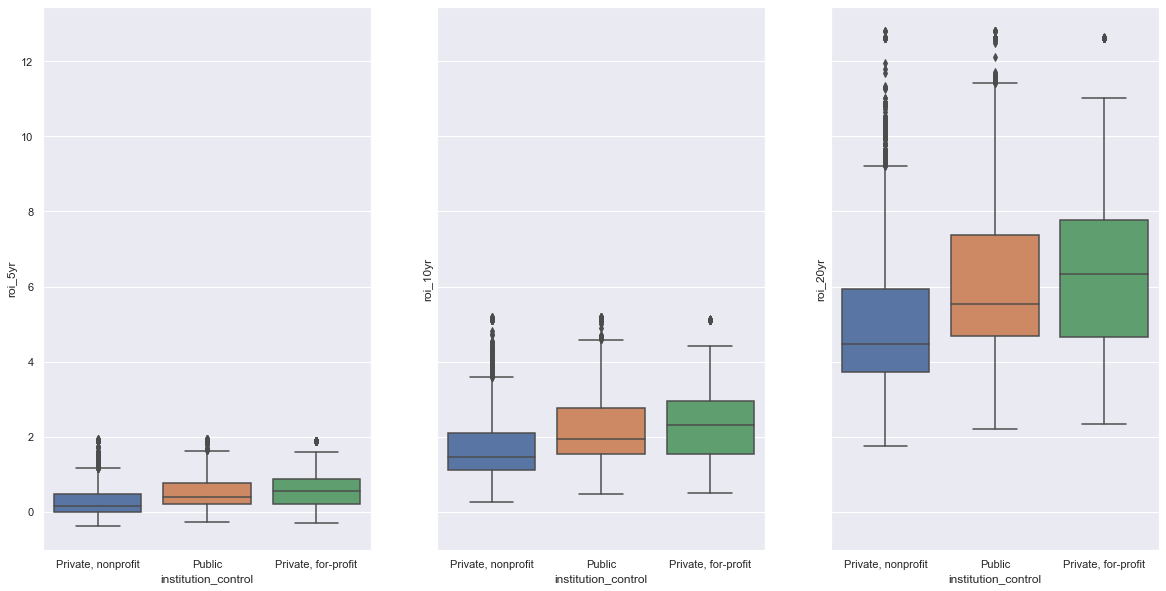

In [41]:
figure, axes = plt.subplots(1,3, sharey = True, figsize=(20,10))
    
sns.boxplot(x='institution_control', y='roi_5yr', data=train1, ax=axes[0])
sns.boxplot(x='institution_control', y='roi_10yr', data=train, ax=axes[1])
sns.boxplot(x='institution_control', y='roi_20yr', data=train, ax=axes[2])

In [91]:
train1.institution_control.value_counts()

Private, nonprofit     20718
Public                 16359
Private, for-profit     1308
Name: institution_control, dtype: int64

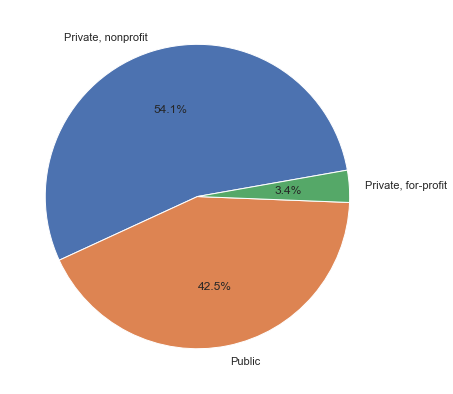

In [42]:
a =20817
b =16359
c =1308
d = a+b+c

plt.figure(figsize=(7,7))
y = np.array([a/d, b/d, c/d])
mylabels = ["Private, nonprofit", "Public", "Private, for-profit"]

plt.pie(y, labels = mylabels, autopct='%1.1f%%', startangle = 10)
plt.show() 

### admission rate by school control

<AxesSubplot:xlabel='institution_control', ylabel='admission_rate'>

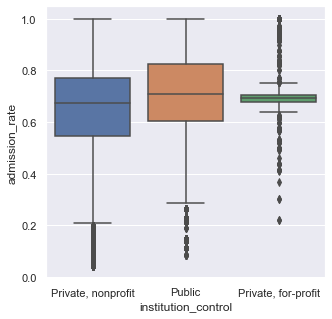

In [45]:
plt.figure(figsize=(5, 5))
sns.boxplot(x='institution_control', y='admission_rate', data = train1)

In [46]:
train1.groupby('institution_control').admission_rate.mean()

institution_control
Private, for-profit                   0.71
Private, nonprofit                    0.63
Public                                0.70
Name: admission_rate, dtype: float64

In [48]:
# cc_prepare.nulls_by_col(train1).head()

### is there any relationship between control and states?

<AxesSubplot:>

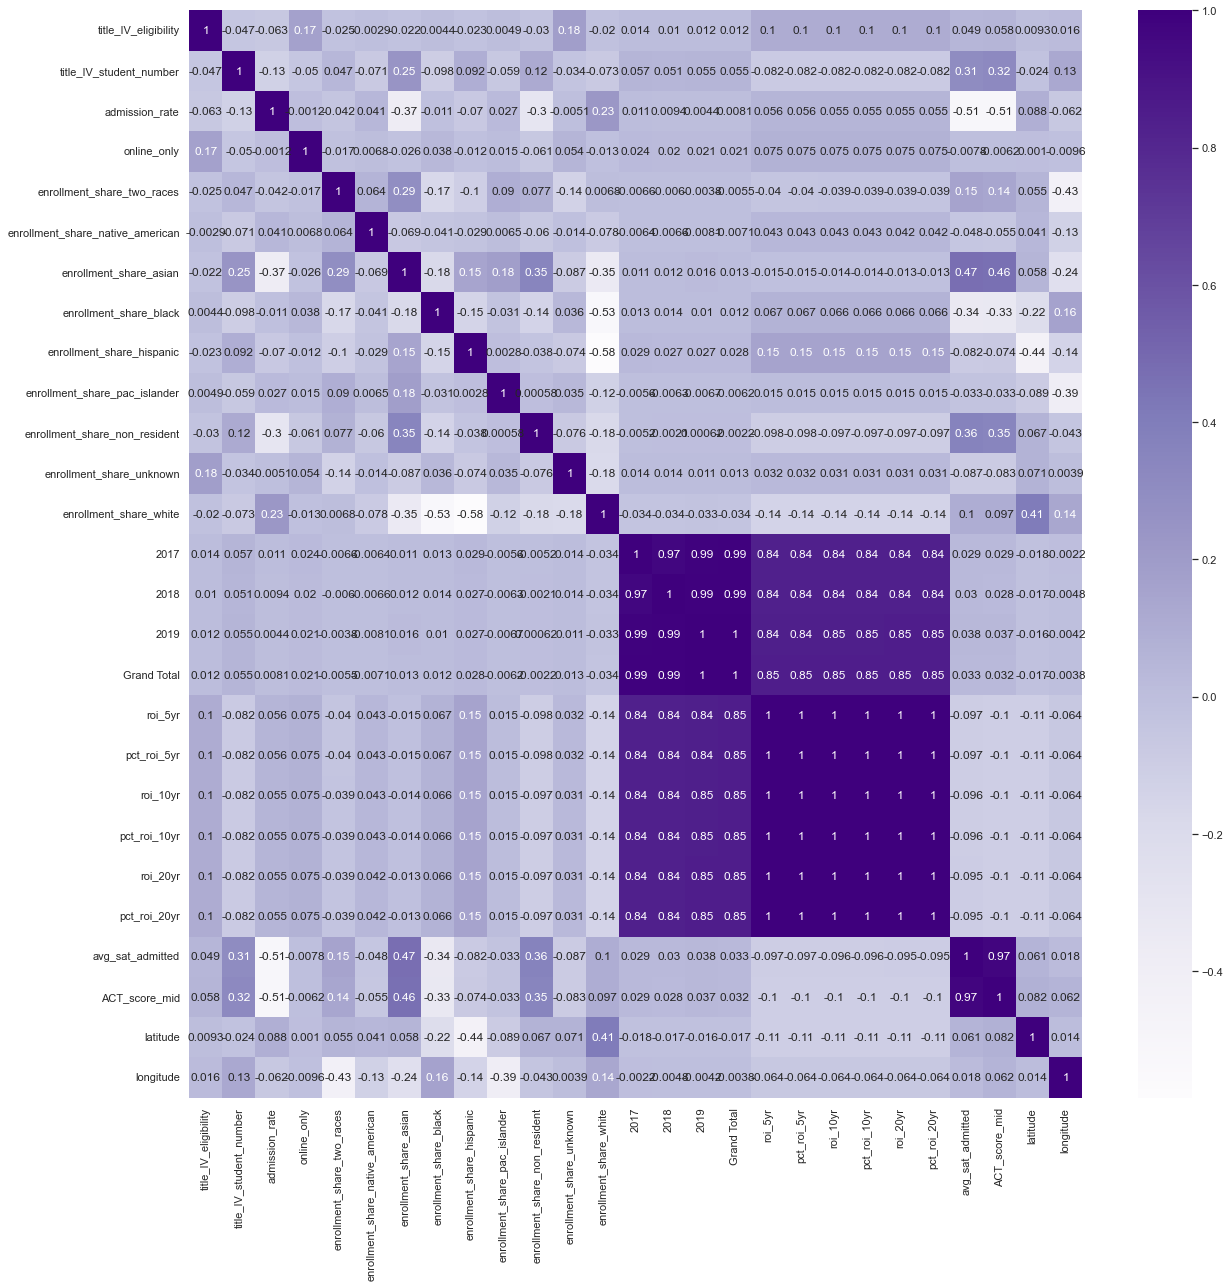

In [58]:
plt.figure(figsize=(20,20))
correlation_table = train1.corr()
sns.heatmap(correlation_table, cmap='Purples', annot=True)

In [59]:
train1.head()

,college_name,institution_control,state_post_code,city,title_IV_eligibility,major_name,title_IV_student_number,admission_rate,online_only,enrollment_share_two_races,...,pct_roi_5yr,roi_10yr,pct_roi_10yr,roi_20yr,pct_roi_20yr,avg_sat_admitted,ACT_score_mid,latitude,longitude,zip_code
0,Baker College,"Private, nonprofit",MI,Owosso,1.00,"Liberal Arts and Sciences, General Studies and...",439.00,0.80,0.00,0.04,...,36.68,1.87,186.52,5.35,534.60,"1,141.94",23.50,44.31,-85.60,48867
1,Widener University,"Private, nonprofit",PA,Chester,1.00,Physics.,649.00,0.69,0.00,0.04,...,37.91,1.94,193.77,5.56,555.86,"1,115.00",23.00,41.20,-77.19,19013-5792
2,William Peace University,"Private, nonprofit",NC,Raleigh,1.00,Criminal Justice and Corrections.,181.00,0.57,0.00,0.04,...,15.08,1.44,143.99,4.43,443.45,"1,042.00",21.00,35.76,-79.02,27604-1194
3,Robert Morris University,"Private, nonprofit",PA,Moon Township,1.00,Health and Physical Education/Fitness.,721.00,0.84,0.00,0.03,...,-5.48,1.00,100.11,3.45,345.41,"1,131.00",25.00,41.20,-77.19,15108-1189
4,Northwestern University,"Private, nonprofit",IL,Evanston,1.00,Urban Studies/Affairs.,775.00,0.08,0.00,0.06,...,16.11,1.48,147.89,4.54,454.00,"1,508.00",34.00,40.63,-89.40,60208


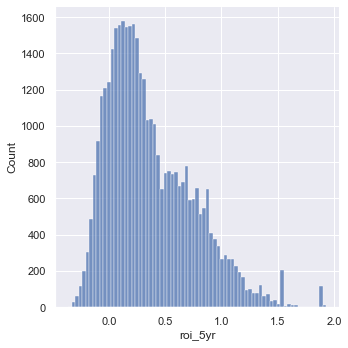

In [67]:
sns.displot(train1.roi_5yr)

In [90]:
train1.columns

Index(['college_name', 'institution_control', 'state_post_code', 'city',
       'title_IV_eligibility', 'major_name', 'title_IV_student_number',
       'admission_rate', 'online_only', 'enrollment_share_two_races',
       'enrollment_share_native_american', 'enrollment_share_asian',
       'enrollment_share_black', 'enrollment_share_hispanic',
       'enrollment_share_pac_islander', 'enrollment_share_non_resident',
       'enrollment_share_unknown', 'enrollment_share_white', 'major_category',
       '2017', '2018', '2019', 'Grand Total', 'roi_5yr', 'pct_roi_5yr',
       'roi_10yr', 'pct_roi_10yr', 'roi_20yr', 'pct_roi_20yr',
       'avg_sat_admitted', 'ACT_score_mid', 'latitude', 'longitude',
       'zip_code'],
      dtype='object')

### Hypotheses testing

1. any relationship between major and states?

        Ho : majors and states have no association (they are indepemdent).

        Ha : majors and states have association (they are depemdent).

In [ ]:
'major_category','state_post_code'

In [79]:
import scipy.stats as stats

In [87]:
alpha = 0.05

observed = pd.crosstab(train1['major_category'], train1.state_post_code)

chi2, p, degf, expected = stats.chi2_contingency(observed)

if p < alpha:
    print("We reject the null hypothesis, majors and states have association (they are depemdent)")
else:
    print("We fail to reject the null hypothesis")

We reject the null hypothesis, majors and states have association (they are depemdent)


2. Any relationship between control and states?

In [91]:
alpha = 0.05

observed = pd.crosstab(train1['institution_control'], train1.state_post_code)

chi2, p, degf, expected = stats.chi2_contingency(observed)

if p < alpha:
    print("We reject the null hypothesis, control and states have association (they are depemdent)")
else:
    print("We fail to reject the null hypothesis")

We reject the null hypothesis, majors and states have association (they are depemdent)


3. ROI and SAT score?
* pearson's R

In [ ]:
'roi_5yr', 'avg_sat_admitted'

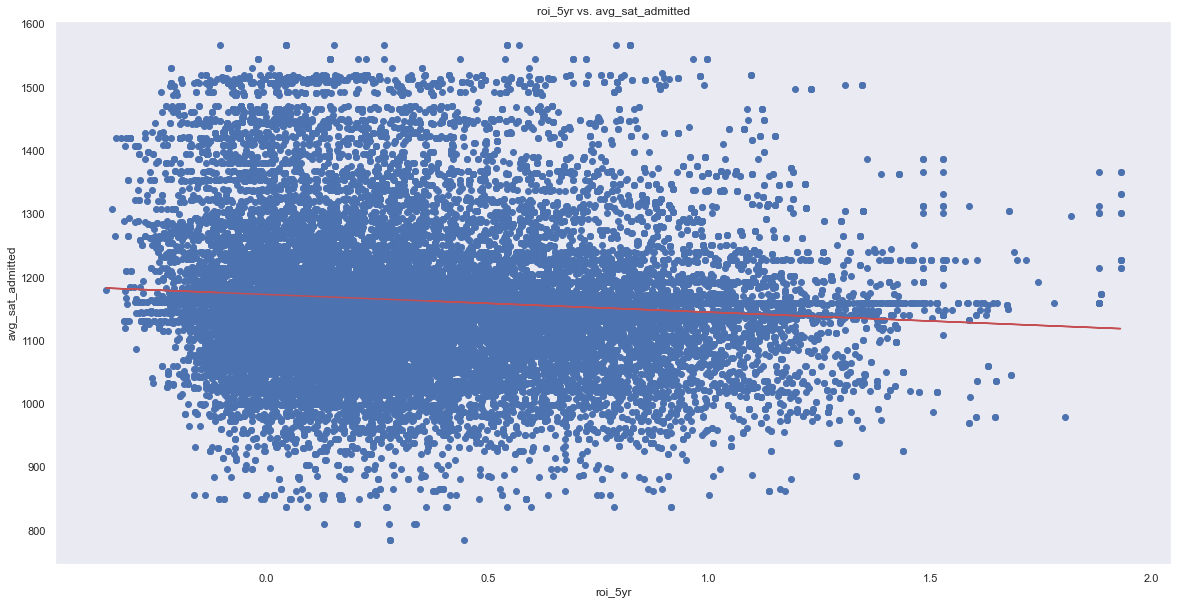

In [114]:
plt.figure(figsize=(20,10))
plt.scatter(train1["roi_5yr"], train1["avg_sat_admitted"])

x = train1["roi_5yr"]
y = train1["avg_sat_admitted"]
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"r")

plt.xlabel("roi_5yr")
plt.ylabel("avg_sat_admitted")
plt.title("roi_5yr vs. avg_sat_admitted")
plt.grid()

H0 : There is no relationship between ROI and SAT score.

Ha : There is a relationship between ROI and SAT score.

In [115]:
alpha = 0.05
r, p = stats.pearsonr(train1["roi_5yr"], train1["avg_sat_admitted"])
if p < alpha:
    print('There is a relationship between ROI and SAT score.')
else:
    print('There is no relationship between ROI and SAT score.')

There is a relationship between ROI and SAT score.


4. RIO and ACT_score_mid ?

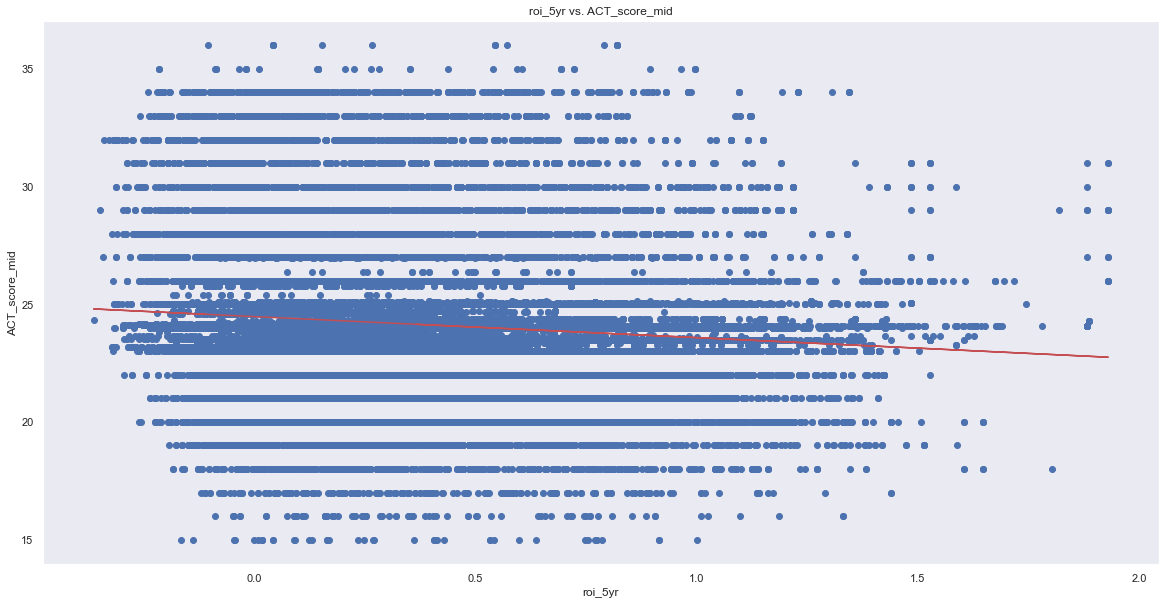

In [116]:
plt.figure(figsize=(20,10))
plt.scatter(train1["roi_5yr"], train1["ACT_score_mid"])

x = train1["roi_5yr"]
y = train1["ACT_score_mid"]
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"r")

plt.xlabel("roi_5yr")
plt.ylabel("ACT_score_mid")
plt.title("roi_5yr vs. ACT_score_mid")
plt.grid()

In [117]:
alpha = 0.05
r, p = stats.pearsonr(train1["roi_5yr"], train1["ACT_score_mid"])
if p < alpha:
    print('There is a relationship between ROI and ACT score.')
else:
    print('There is no relationship between ROI and ACT score.')

There is a relationship between ROI and ACT score.


5. state and ROI?

<AxesSubplot:xlabel='state_post_code', ylabel='roi_5yr'>

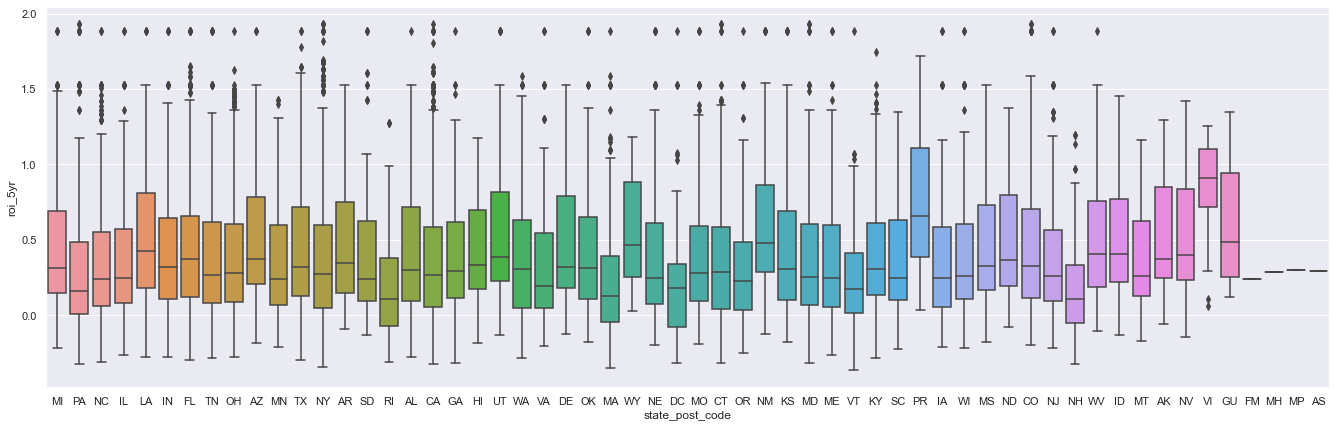

In [118]:
plt.figure(figsize=(23, 7))
sns.boxplot(x='state_post_code', y='roi_5yr', data = train1)

6. school control and ROI?

<AxesSubplot:xlabel='institution_control', ylabel='roi_5yr'>

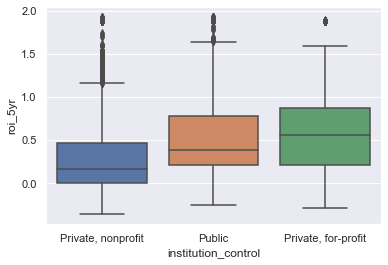

In [119]:
sns.boxplot(x='institution_control', y='roi_5yr', data=train1)

In [113]:
train_imputed = pd.read_csv('train_imputed.csv')
train_imputed.shape

(38385, 135)

In [111]:
basic_info_cols = ['college_name','institution_control',
                   'state_post_code','city','title_IV_eligibility',
                   'major_name','title_IV_student_number','admission_rate', 
                   'online_only','enrollment_share_two_races','enrollment_share_native_american',
                   'enrollment_share_asian','enrollment_share_black',
                   'enrollment_share_hispanic','enrollment_share_pac_islander',
                   'enrollment_share_non_resident','enrollment_share_unknown',
                   'enrollment_share_white','major_category','2017','2018','2019','Grand Total',
                   'roi_5yr','pct_roi_5yr','roi_10yr','pct_roi_10yr','roi_20yr','pct_roi_20yr',
                   'avg_sat_admitted']
train_imputed1 = train_imputed[basic_info_cols]
train_imputed1.shape

(38385, 30)

In [69]:
# cc_prepare.nulls_by_col(train_imputed).head()

In [70]:
# cc_prepare.nulls_by_col(train_imputed1).head()